In [58]:
import pandas as pd
import numpy as np
import math
import cv2
import datetime
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from PIL import Image
import time

In [59]:
def extract_seed_pixels(stroke_image, original_image):
    """
    Extracts foreground and background seed pixels based on stroke colors.
    
    Parameters:
    - stroke_image: Image with strokes
    - original_image: Original image to be segmented
    
    Returns:
    - Array of foreground seed pixels
    - Array of background seed pixels
    """
    stroke_array = np.array(stroke_image)
    original_array = np.array(original_image)
    
    blue_color = np.array([6, 0, 255])
    red_color = np.array([255, 0, 0])
    
    foreground_seeds = []
    background_seeds = []
    
    background_seeds = original_array[(stroke_array == blue_color).all(axis=-1)]
    foreground_seeds = original_array[(stroke_array == red_color).all(axis=-1)]
    
    timestamp = datetime.datetime.now().strftime("%M:%S")
    print("Log : Seed pixels extracted at", timestamp)
    
    return np.array(foreground_seeds), np.array(background_seeds)

In [60]:
def initialize_centroids(seeds, num_clusters):
    """
    Initializes centroids randomly from the seeds.
    
    Parameters:
    - seeds: Array of seed pixels
    - num_clusters: Number of clusters
    
    Returns:
    - Array of initialized centroids
    """
    np.random.seed(0)
    num_seeds = len(seeds)
    timestamp = datetime.datetime.now().strftime("%M:%S")
    print("Log: Number of seeds: ", num_seeds, " at: ", timestamp)
    permuted_indices = np.random.permutation(num_seeds)
    random_indices = permuted_indices[:num_clusters]    
    centroids = seeds[random_indices]
    timestamp = datetime.datetime.now().strftime("%M:%S")
    print("Log: Centroids initialized at: ", timestamp)
    return centroids

In [61]:
def assign_to_closest_centroids(seeds, centroids):
    """
    Assigns each seed to the closest centroid.
    
    Parameters:
    - seeds: Array of seed pixels
    - centroids: Current centroids
    
    Returns:
    - Array of indices indicating the closest centroid for each seed
    """
    differences = seeds - centroids[:, np.newaxis]

    # Square the differences
    squared_differences = differences**2

    # Sum the squared differences along the last axis
    sum_of_squares = squared_differences.sum(axis=2)

    # Take the square root of the sum of squares to get the Euclidean distance
    distances = np.sqrt(sum_of_squares)

    # Find the index of the closest centroid for each seed
    closest_centroids = np.argmin(distances, axis=0)
    return closest_centroids

In [62]:
def update_centroids(seeds, assignments, num_clusters):
    """
    Updates centroids based on current assignment of seeds.
    
    Parameters:
    - seeds: Array of seed pixels
    - assignments: Array of assignments to centroids
    - num_clusters: Number of clusters
    
    Returns:
    - Array of updated centroids
    """
    # Initialize an empty list to store the new centroids
    new_centroids_list = []

    # Loop over each cluster
    for k in range(num_clusters):
        # Get the seeds assigned to the current cluster
        cluster_seeds = seeds[assignments == k]
        
        # Calculate the mean of the seeds, which is the new centroid
        new_centroid = cluster_seeds.mean(axis=0)
        
        # Append the new centroid to the list
        new_centroids_list.append(new_centroid)

    # Convert the list of new centroids to a numpy array
    new_centroids = np.array(new_centroids_list)    
    return new_centroids

In [63]:
def perform_kmeans_clustering(seeds, num_clusters, convergence_threshold=0.01, max_iterations=100):
    """
    Performs K-Means clustering on the seeds and returns cluster centers and labels.
    
    Parameters:
    - seeds: Array of seed pixels
    - num_clusters: Number of clusters
    - convergence_threshold: Convergence threshold for stopping iterations (default: 0.01)
    - max_iterations: Maximum number of iterations (default: 100)
    
    Returns:
    - Cluster centers
    - Cluster labels
    """
    centroids = initialize_centroids(seeds, num_clusters)
    prev_centroids = centroids.copy()
    iterations = 0
    
    while True:
        assignments = assign_to_closest_centroids(seeds, centroids)
        centroids = update_centroids(seeds, assignments, num_clusters)
        
        # Calculate the change in centroids
        centroid_change = np.abs(centroids - prev_centroids).mean()
        
        if centroid_change < convergence_threshold or iterations >= max_iterations:
                timestamp = datetime.datetime.now().strftime("%M:%S")
                print("Breaking K-means due to conversion being reached at: ", timestamp,  " with change: ", centroid_change, " and iterations: ", iterations)
                break
        
        prev_centroids = centroids.copy()
        iterations += 1
    
    return centroids, assignments

In [64]:
def calculate_likelihood(image, foreground_centers, background_centers, weight=0.1):
    """
    Calculates the likelihood of each pixel in the image being part of the foreground 
    or background using the weighted Euclidean distance (without squaring) formula.
    
    Parameters:
    - image (np.array): Original image to be segmented as a NumPy array.
    - foreground_centers (np.array): Cluster centers for foreground.
    - background_centers (np.array): Cluster centers for background.
    - weight (float): The weight value for each cluster, defaulted to 0.1 as specified.
    
    Returns:
    - np.array: Binary mask of the segmented image.
    """
    image_array = image
    binary_mask = np.zeros(image_array.shape[:2], dtype=np.uint8)
    
    for i in range(len(image_array)):
        for j in range(len(image_array[0])):
            pixel = image_array[i][j]
            
            # Calculate foreground likelihood without the squared distance
            foreground_likelihood = sum([weight * math.exp(-np.linalg.norm(pixel - fc)) for fc in foreground_centers])
            
            # Calculate background likelihood without the squared distance
            background_likelihood = sum([weight * math.exp(-np.linalg.norm(pixel - bc)) for bc in background_centers])
            
            # Assign pixel to the class with higher likelihood
            binary_mask[i][j] = 255 if foreground_likelihood > background_likelihood else 0
    
    timestamp = datetime.datetime.now().strftime("%M:%S")
    print("Log: Likelihood of all pixels calculated at: ", timestamp)
    return binary_mask

In [65]:
def display_segmentation(original_image, binary_mask):
    """
    Applies the binary mask to the original image to segment the foreground and
    set the background to white.

    Parameters:
    - original_image (np.array): The original image as a NumPy array.
    - binary_mask (np.array): The binary mask where the foreground is 255.

    Returns:
    - np.array: The original image with the background set to white.
    - np.array: The original image with the foreground preserved and background set to white.
    """
    # Create a 3-channel mask to handle color images
    three_channel_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)

    # Use the mask to select the foreground
    foreground = cv2.bitwise_and(original_image, three_channel_mask)

    # Invert the mask to create the inverse mask
    inverse_mask = cv2.bitwise_not(three_channel_mask)

    # Create a white background of the same size as the original image
    white_background = np.full_like(original_image, 255)

    # Use the inverse mask to put the white background in place of the background
    background_filled_white = cv2.bitwise_or(foreground, inverse_mask)

    # Show the original image with the foreground preserved and background white
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Show the image with the background set to white
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(background_filled_white, cv2.COLOR_BGR2RGB))
    plt.title('Lazy Snapping Output')
    plt.axis('off')

    plt.show()
    timestamp = datetime.datetime.now().strftime("%M:%S")
    print("Log: Images displayed at ", timestamp)
    return original_image, background_filled_white

In [66]:
def lazy_snapping(original_image, stroke_image, num_clusters):
    """
    Main function that orchestrates the Lazy Snapping algorithm.
    
    Parameters:
    original_image (PIL.Image): Original image to be segmented.
    stroke_image (PIL.Image): Image with red and blue strokes for foreground and background seeds.
    num_clusters (int): The number of clusters to use in K-Means.

    Returns:
    np.array: Image with foreground highlighted.
    np.array: Image with background highlighted.
    """
    start_time = time.time()

    # Extract seed pixels for foreground and background from the stroke image
    foreground_seeds, background_seeds = extract_seed_pixels(stroke_image, original_image)

    # Perform K-Means clustering to find the centroids for foreground and background seeds
    foreground_centers, _ = perform_kmeans_clustering(foreground_seeds, num_clusters)
    background_centers, _ = perform_kmeans_clustering(background_seeds, num_clusters)

    # Calculate the probability mask for the image based on the clustering results
    probability_mask = calculate_likelihood(original_image, foreground_centers, background_centers)

    # Use the probability mask to display the segmentation results
    foreground_highlighted, background_highlighted = display_segmentation(original_image, probability_mask)

    end_time = time.time()
    print("Lazy Snapping process time in seconds: {:.2f}".format((end_time - start_time)))

    return foreground_highlighted, background_highlighted

In [69]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler

def find_optimal_k(image):
    timestamp = datetime.datetime.now().strftime("%M:%S")
    print("Log: Finding optimum k value starting at: ", timestamp)

    # Reshape the image to be a list of RGB values
    image_2d = image.reshape(-1, 3)
    
    # Standardize the data
    scaler = StandardScaler()
    image_2d = scaler.fit_transform(image_2d)
    
    wcss = []
    K = range(1,10)

    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(image_2d)
        wcss.append(kmeanModel.inertia_)

    # Find the elbow point programmatically
    kn = KneeLocator(K, wcss, curve='convex', direction='decreasing')
    print("Optimal K value: ",  kn.knee)
    plt.xlabel('k')
    plt.ylabel('WCSS')
    plt.plot(K, wcss, 'bx-')
    plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    plt.show()

    timestamp = datetime.datetime.now().strftime("%M:%S")
    print("Log: Optimum value of k found at ", timestamp)
    return kn.knee

Log: Finding optimum k value starting at:  44:51


c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\

Optimal K value:  3


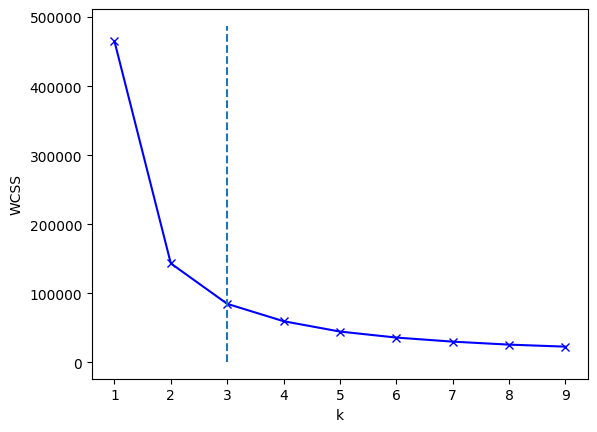

Log: Optimum value of k found at  44:56
Log : Seed pixels extracted at 44:56
Log: Number of seeds:  1346  at:  44:56
Log: Centroids initialized at:  44:56
Breaking K-means due to conversion being reached at:  44:56  with change:  0.0  and iterations:  28
Log: Number of seeds:  2039  at:  44:56
Log: Centroids initialized at:  44:56
Breaking K-means due to conversion being reached at:  44:56  with change:  0.0  and iterations:  12
Log: Likelihood of all pixels calculated at:  45:00


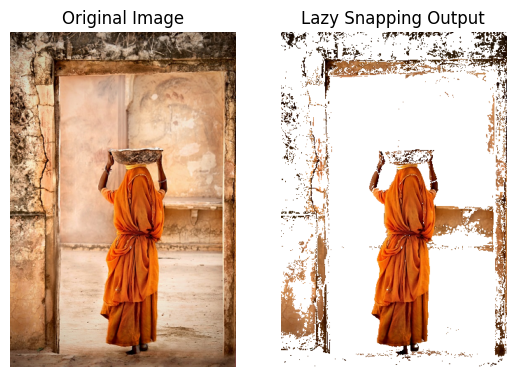

Log: Images displayed at  45:00
Lazy Snapping process time in seconds: 4.18


(array([[[ 33,  58,  84],
         [  0,   4,  21],
         [  0,   0,   5],
         ...,
         [ 37,  46,  65],
         [ 37,  43,  65],
         [ 49,  57,  81]],
 
        [[ 49,  73, 104],
         [  9,  24,  44],
         [  4,   9,  22],
         ...,
         [ 13,  22,  40],
         [  7,  14,  33],
         [ 52,  61,  81]],
 
        [[ 51,  69,  95],
         [  7,  12,  31],
         [  8,  20,  37],
         ...,
         [ 68,  77,  94],
         [101, 110, 128],
         [ 66,  77,  96]],
 
        ...,
 
        [[ 52,  68,  94],
         [ 49,  65,  92],
         [ 55,  76, 104],
         ...,
         [ 52,  72, 104],
         [ 59,  74, 112],
         [ 67,  71, 129]],
 
        [[ 53,  67,  95],
         [ 46,  64,  93],
         [ 52,  70, 101],
         ...,
         [ 56,  76, 108],
         [ 62,  76, 116],
         [ 66,  71, 129]],
 
        [[ 51,  68,  95],
         [ 52,  70,  99],
         [ 54,  73, 103],
         ...,
         [ 46,  67,  98],
  

In [70]:
lady=cv2.imread('filepath')
ladys2=Image.open('filepath')
ladys1 =Image.open('filepath')
lazy_snapping(lady,ladys2,find_optimal_k(np.array(Image.open('filepath'))))

Log: Finding optimum k value starting at:  45:00


c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\

Optimal K value:  2


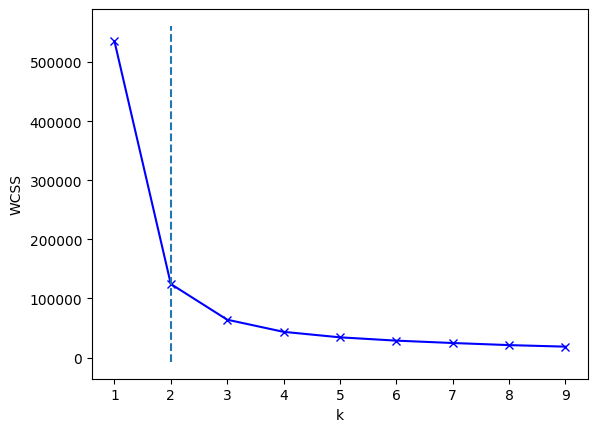

Log: Optimum value of k found at  45:07
Log : Seed pixels extracted at 45:07
Log: Number of seeds:  1899  at:  45:07
Log: Centroids initialized at:  45:07
Breaking K-means due to conversion being reached at:  45:07  with change:  0.0  and iterations:  4
Log: Number of seeds:  2921  at:  45:07
Log: Centroids initialized at:  45:07
Breaking K-means due to conversion being reached at:  45:07  with change:  0.0  and iterations:  5
Log: Likelihood of all pixels calculated at:  45:10


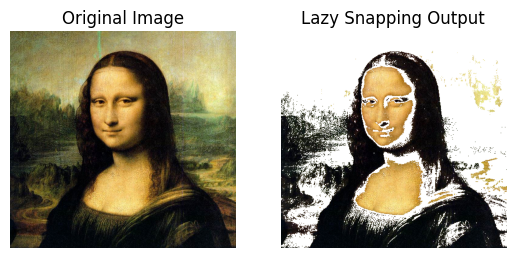

Log: Images displayed at  45:10
Lazy Snapping process time in seconds: 3.44


(array([[[ 63, 109, 107],
         [ 62, 104, 103],
         [ 54,  92,  94],
         ...,
         [162, 186, 187],
         [150, 181, 178],
         [154, 187, 183]],
 
        [[ 44,  93,  91],
         [ 38,  82,  82],
         [ 67, 105, 107],
         ...,
         [154, 180, 180],
         [149, 181, 178],
         [147, 181, 177]],
 
        [[ 53, 105, 103],
         [ 51,  99,  98],
         [ 54,  98, 100],
         ...,
         [150, 181, 181],
         [143, 176, 172],
         [149, 185, 181]],
 
        ...,
 
        [[ 32,  42,  39],
         [ 37,  48,  46],
         [ 29,  42,  40],
         ...,
         [ 47,  49,  51],
         [ 30,  36,  36],
         [ 41,  47,  48]],
 
        [[ 28,  38,  32],
         [ 26,  36,  32],
         [ 21,  33,  31],
         ...,
         [ 27,  27,  25],
         [ 33,  36,  34],
         [ 38,  40,  39]],
 
        [[ 24,  33,  24],
         [ 24,  32,  24],
         [ 26,  33,  27],
         ...,
         [ 33,  31,  27],
  

In [71]:
mona=cv2.imread('filepath')
monsastroke=Image.open('filepath')
lazy_snapping(mona,monsastroke,find_optimal_k(np.array(Image.open('filepath'))))

Log: Finding optimum k value starting at:  45:10


c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\

Optimal K value:  2


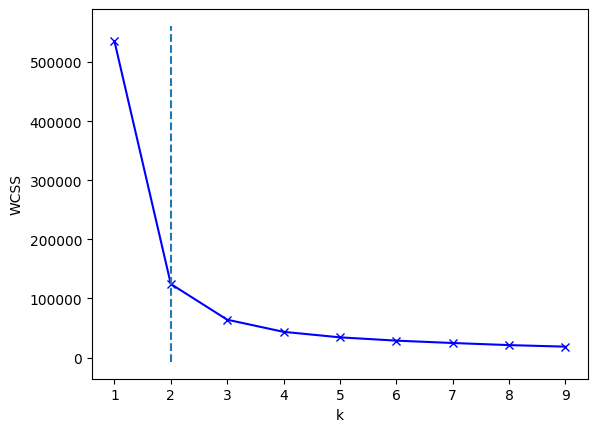

Log: Optimum value of k found at  45:16
Log : Seed pixels extracted at 45:16
Log: Number of seeds:  943  at:  45:16
Log: Centroids initialized at:  45:16
Breaking K-means due to conversion being reached at:  45:16  with change:  0.0  and iterations:  15
Log: Number of seeds:  1944  at:  45:16
Log: Centroids initialized at:  45:16
Breaking K-means due to conversion being reached at:  45:16  with change:  0.0  and iterations:  8
Log: Likelihood of all pixels calculated at:  45:19


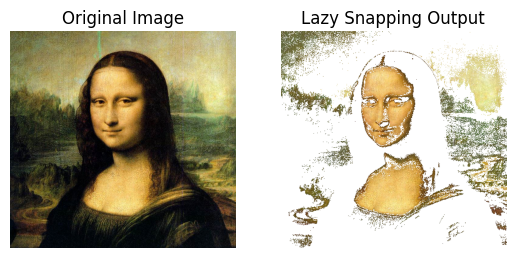

Log: Images displayed at  45:20
Lazy Snapping process time in seconds: 3.52


(array([[[ 63, 109, 107],
         [ 62, 104, 103],
         [ 54,  92,  94],
         ...,
         [162, 186, 187],
         [150, 181, 178],
         [154, 187, 183]],
 
        [[ 44,  93,  91],
         [ 38,  82,  82],
         [ 67, 105, 107],
         ...,
         [154, 180, 180],
         [149, 181, 178],
         [147, 181, 177]],
 
        [[ 53, 105, 103],
         [ 51,  99,  98],
         [ 54,  98, 100],
         ...,
         [150, 181, 181],
         [143, 176, 172],
         [149, 185, 181]],
 
        ...,
 
        [[ 32,  42,  39],
         [ 37,  48,  46],
         [ 29,  42,  40],
         ...,
         [ 47,  49,  51],
         [ 30,  36,  36],
         [ 41,  47,  48]],
 
        [[ 28,  38,  32],
         [ 26,  36,  32],
         [ 21,  33,  31],
         ...,
         [ 27,  27,  25],
         [ 33,  36,  34],
         [ 38,  40,  39]],
 
        [[ 24,  33,  24],
         [ 24,  32,  24],
         [ 26,  33,  27],
         ...,
         [ 33,  31,  27],
  

In [72]:
mona=cv2.imread('filepath')
monsastroke2=Image.open('filepath)
lazy_snapping(mona,monsastroke2,find_optimal_k(np.array(Image.open('filepath'))))

In [73]:
def extract_seed_pixels_van(stroke_image, original_image, tolerance=10):
    # If the stroke image has an alpha channel, ignore it
    if stroke_image.shape[2] == 4:
        stroke_image = stroke_image[:, :, :3]

    # Define the RGB color arrays
    blue_color = np.array([6, 0, 255])  # Blue in RGB
    red_color = np.array([255, 0, 0])   # Red in RGB

    # Create masks for the stroke colors
    background_mask = np.all(np.abs(stroke_image - blue_color) < tolerance, axis=-1)
    foreground_mask = np.all(np.abs(stroke_image - red_color) < tolerance, axis=-1)

    # Use masks to extract the seed pixels
    background_seeds = original_image[background_mask]
    foreground_seeds = original_image[foreground_mask]

    return foreground_seeds, background_seeds

def lazy_snapping_van(original_image, stroke_image, num_clusters):
    """
    Main function that orchestrates the Lazy Snapping algorithm.
    
    Parameters:
    original_image (PIL.Image): Original image to be segmented.
    stroke_image (PIL.Image): Image with red and blue strokes for foreground and background seeds.
    num_clusters (int): The number of clusters to use in K-Means.

    Returns:
    np.array: Image with foreground highlighted.
    np.array: Image with background highlighted.
    """
    start_time = time.time()

    # Extract seed pixels for foreground and background from the stroke image
    monsastroke2_array = np.array(monsastroke2)[:, :, :3]  # Discard the alpha channel if present
    foreground_seeds, background_seeds = extract_seed_pixels_van(monsastroke2_array, mona)
    # Perform K-Means clustering to find the centroids for foreground and background seeds
    foreground_centers, _ = perform_kmeans_clustering(foreground_seeds, num_clusters)
    background_centers, _ = perform_kmeans_clustering(background_seeds, num_clusters)

    # Calculate the probability mask for the image based on the clustering results
    probability_mask = calculate_likelihood(original_image, foreground_centers, background_centers)

    # Use the probability mask to display the segmentation results
    foreground_highlighted, background_highlighted = display_segmentation(original_image, probability_mask)

    end_time = time.time()
    print("Lazy Snapping process time in minutes: {:.2f}".format((end_time - start_time) / 60))

    return foreground_highlighted, background_highlighted

Log: Finding optimum k value starting at:  45:37


c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hashim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\

Optimal K value:  3


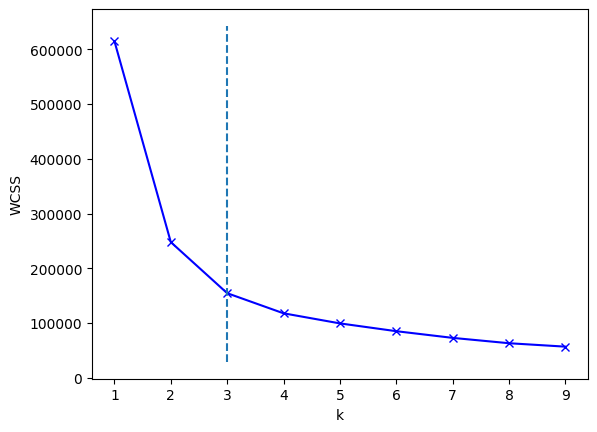

Log: Optimum value of k found at  45:44
Log: Number of seeds:  7526  at:  45:44
Log: Centroids initialized at:  45:44
Breaking K-means due to conversion being reached at:  45:44  with change:  0.0  and iterations:  24
Log: Number of seeds:  9224  at:  45:44
Log: Centroids initialized at:  45:44
Breaking K-means due to conversion being reached at:  45:45  with change:  0.007602972363571325  and iterations:  28
Log: Likelihood of all pixels calculated at:  45:50


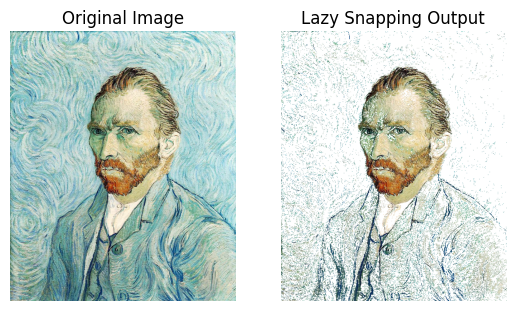

Log: Images displayed at  45:50
Lazy Snapping process time in minutes: 0.09


(array([[[ 86, 100,  34],
         [148, 160,  98],
         [137, 144,  90],
         ...,
         [220, 222, 176],
         [216, 215, 189],
         [255, 255, 255]],
 
        [[130, 143,  81],
         [157, 168, 109],
         [199, 208, 157],
         ...,
         [225, 229, 184],
         [238, 237, 212],
         [253, 250, 248]],
 
        [[168, 178, 124],
         [183, 192, 141],
         [214, 221, 177],
         ...,
         [230, 234, 190],
         [228, 228, 203],
         [253, 251, 249]],
 
        ...,
 
        [[174, 171, 141],
         [170, 171, 144],
         [166, 167, 149],
         ...,
         [201, 213, 172],
         [206, 219, 172],
         [189, 202, 154]],
 
        [[129, 139, 111],
         [170, 184, 163],
         [ 82,  98,  88],
         ...,
         [202, 215, 171],
         [216, 231, 184],
         [183, 200, 154]],
 
        [[149, 158, 121],
         [156, 171, 142],
         [162, 183, 167],
         ...,
         [192, 202, 157],
  

In [75]:
van=cv2.imread('filepath')
van2=Image.open('filepath')
lazy_snapping_van(mona,monsastroke2,find_optimal_k(np.array(Image.open('filepath'))) )